In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATv2Conv
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import DataLoader
from torch_geometric.data import Data
from torch.utils.data import Dataset
from torch_geometric.nn.models import TGNMemory
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from torch_geometric.utils import add_self_loops
import random

In [14]:
# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, data_list):
        self.data = data_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        edge_index = self.data[idx]['edge_index']  # Shape: (2, num_edges)
        node_features = self.data[idx]['node_features']  # Shape: (num_nodes, num_features)
        temporal_data = self.data[idx]['temporal_data']  # Shape: (num_nodes, seq_length)
        crop_type = self.data[idx]['crop_type']  # Encoding for millet or rice
        task_labels = self.data[idx]['task_labels']  # List of task-specific labels
        return edge_index, node_features, temporal_data, crop_type, task_labels


In [15]:
# Enhanced Multi-Task Model
class EnhancedMultiTaskModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_hidden, num_tasks, output_dims):
        super(EnhancedMultiTaskModel, self).__init__()
        self.gcn = GCNConv(input_dim, hidden_dim)
        self.gat = GATConv(hidden_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, lstm_hidden, batch_first=True)
        self.task_heads = nn.ModuleList([nn.Linear(lstm_hidden, output_dim) for output_dim in output_dims])

    def forward(self, edge_index, node_features, temporal_data, crop_type):
        # Graph-based processing
        x = self.gcn(node_features, edge_index)
        x = F.relu(x)
        x = self.gat(x, edge_index)
        x = F.relu(x)

        # Incorporate temporal data
        temporal_input = torch.cat((x, temporal_data), dim=-1)
        temporal_output, _ = self.lstm(temporal_input.unsqueeze(0))  # Add batch dimension for LSTM
        temporal_output = temporal_output.squeeze(0)  # Remove batch dimension

        # Task-specific outputs
        outputs = [head(temporal_output) for head in self.task_heads]
        return outputs



In [16]:
# Training Function
def train_model(model, dataloader, optimizer, criterion, num_tasks):
    model.train()
    total_loss = 0
    for edge_index, node_features, temporal_data, crop_type, task_labels in dataloader:
        optimizer.zero_grad()
        outputs = model(edge_index, node_features, temporal_data, crop_type)
        loss = sum(criterion(outputs[i], task_labels[i]) for i in range(num_tasks))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


In [17]:
# Evaluation Function
def evaluate_model(model, dataloader, criterion, num_tasks):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for edge_index, node_features, temporal_data, crop_type, task_labels in dataloader:
            outputs = model(edge_index, node_features, temporal_data, crop_type)
            loss = sum(criterion(outputs[i], task_labels[i]) for i in range(num_tasks))
            total_loss += loss.item()
    return total_loss / len(dataloader)

In [18]:

# Generate Synthetic Temporal Data
def generate_synthetic_time_series(start_year, end_year, num_points, trend=0.1, seasonal_amplitude=0.05, noise_level=0.02):
    years = np.linspace(start_year, end_year, num_points)
    values = trend * (years - start_year) + seasonal_amplitude * np.sin(2 * np.pi * (years - start_year))
    values += np.random.normal(scale=noise_level, size=num_points)
    return years, values

# Example Dataset Creation
num_nodes = 10
num_edges = 20
num_features = 16
seq_length = 5
num_tasks = 4
output_dims = [1, 1, 1, 1]  # Predict BloodSugar, Production, WaterUsage, Affordability

# Generate synthetic dataset
data_list = []
synthetic_data = []  # To store data for CSV creation
for _ in range(100):
    edge_index = torch.randint(0, num_nodes, (2, num_edges))
    edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)
    node_features = torch.rand(num_nodes, num_features)
    temporal_data = torch.rand(num_nodes, seq_length)
    crop_type = torch.randint(0, 2, (num_nodes,))  # 0 for millet, 1 for rice
    task_labels = [
        torch.rand(num_nodes, output_dims[0]),  # Regression labels for BloodSugar
        torch.rand(num_nodes, output_dims[1]),  # Regression labels for Production
        torch.rand(num_nodes, output_dims[2]),  # Regression labels for WaterUsage
        torch.rand(num_nodes, output_dims[3])   # Regression labels for Affordability
    ]
    data = {
        'edge_index': edge_index,
        'node_features': node_features,
        'temporal_data': temporal_data,
        'crop_type': crop_type,
        'task_labels': task_labels
    }
    data_list.append(data)

    # Prepare synthetic data for CSV
    for i in range(num_nodes):
        synthetic_data.append({
            'Node': i,
            'CropType': 'Millet' if crop_type[i].item() == 0 else 'Rice',
            'BloodSugar': task_labels[0][i].item(),
            'Production': task_labels[1][i].item(),
            'WaterUsage': task_labels[2][i].item(),
            'Affordability': task_labels[3][i].item()
        })

# Save synthetic data to CSV
df = pd.DataFrame(synthetic_data)
df.to_csv("synthetic_dataset.csv", index=False)
print("Synthetic dataset saved as 'synthetic_dataset.csv'")

Synthetic dataset saved as 'synthetic_dataset.csv'


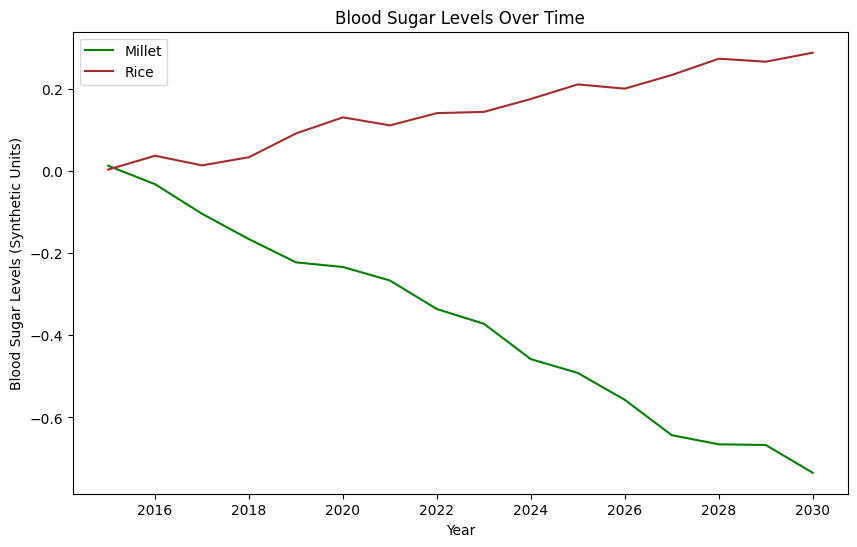

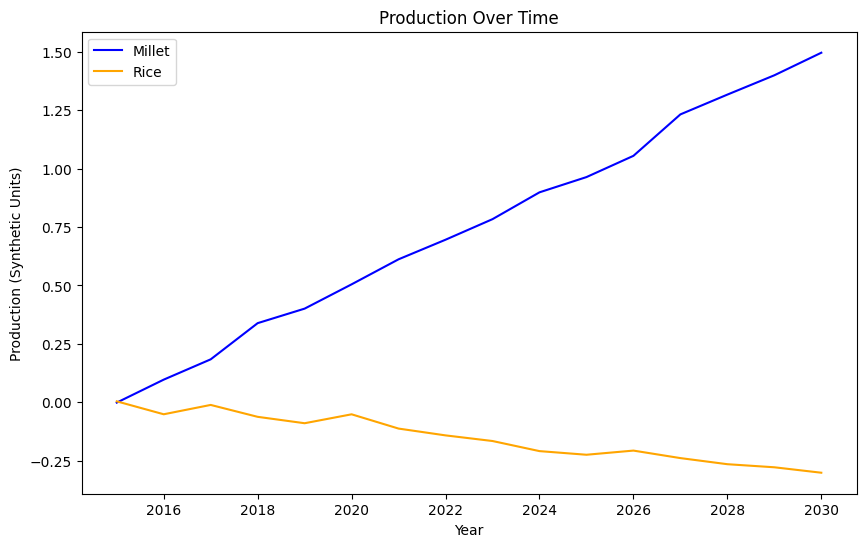

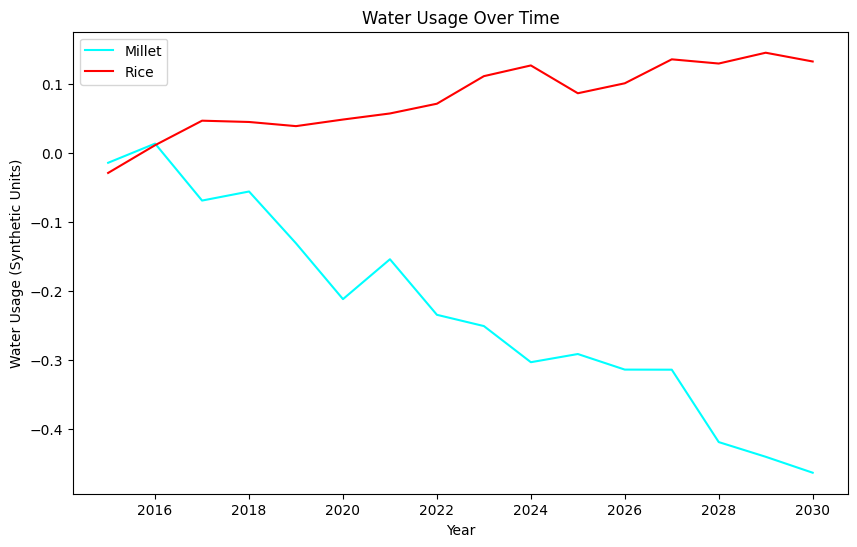

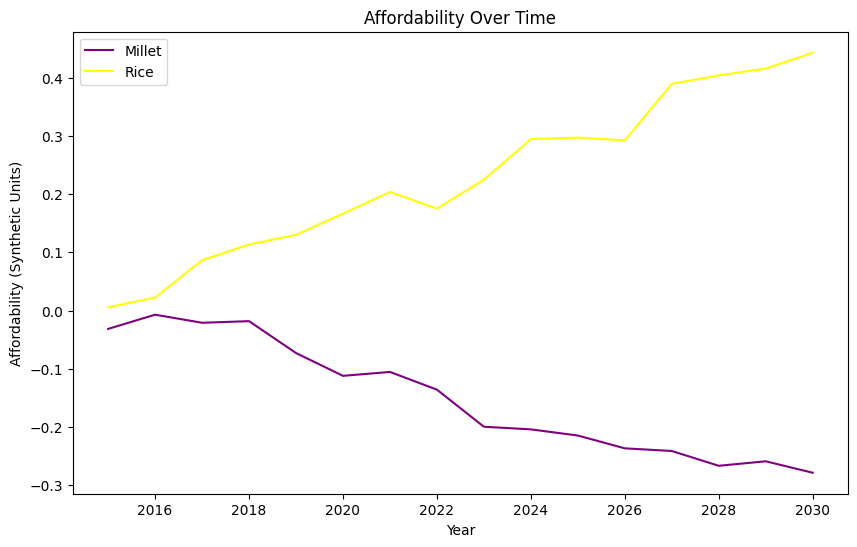

In [19]:
# Generate synthetic time-series data for visualization
start_year = 2015
end_year = 2030
num_points = 16  # 5 years past + 5 years future + 6 intermediate points

# BloodSugar trends
years, blood_sugar_millet = generate_synthetic_time_series(start_year, end_year, num_points, trend=-0.05)
_, blood_sugar_rice = generate_synthetic_time_series(start_year, end_year, num_points, trend=0.02)

# Production trends
_, production_millet = generate_synthetic_time_series(start_year, end_year, num_points, trend=0.1)
_, production_rice = generate_synthetic_time_series(start_year, end_year, num_points, trend=-0.02)

# WaterUsage trends
_, water_usage_millet = generate_synthetic_time_series(start_year, end_year, num_points, trend=-0.03)
_, water_usage_rice = generate_synthetic_time_series(start_year, end_year, num_points, trend=0.01)

# Affordability trends
_, affordability_millet = generate_synthetic_time_series(start_year, end_year, num_points, trend=-0.02)
_, affordability_rice = generate_synthetic_time_series(start_year, end_year, num_points, trend=0.03)

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(years, blood_sugar_millet, label='Millet', color='green')
plt.plot(years, blood_sugar_rice, label='Rice', color='brown')
plt.title('Blood Sugar Levels Over Time')
plt.xlabel('Year')
plt.ylabel('Blood Sugar Levels (Synthetic Units)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(years, production_millet, label='Millet', color='blue')
plt.plot(years, production_rice, label='Rice', color='orange')
plt.title('Production Over Time')
plt.xlabel('Year')
plt.ylabel('Production (Synthetic Units)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(years, water_usage_millet, label='Millet', color='cyan')
plt.plot(years, water_usage_rice, label='Rice', color='red')
plt.title('Water Usage Over Time')
plt.xlabel('Year')
plt.ylabel('Water Usage (Synthetic Units)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(years, affordability_millet, label='Millet', color='purple')
plt.plot(years, affordability_rice, label='Rice', color='yellow')
plt.title('Affordability Over Time')
plt.xlabel('Year')
plt.ylabel('Affordability (Synthetic Units)')
plt.legend()
plt.show()

In [20]:
df = pd.DataFrame(synthetic_data)

In [21]:
df

,Node,CropType,BloodSugar,Production,WaterUsage,Affordability
0,0,Millet,0.948021,0.112641,0.060775,0.773673
1,1,Rice,0.542755,0.335954,0.725488,0.386149
2,2,Rice,0.345548,0.974109,0.113522,0.455694
3,3,Millet,0.630206,0.083905,0.428985,0.249073
4,4,Millet,0.785354,0.125465,0.269597,0.599134
...,...,...,...,...,...,...
995,5,Millet,0.242641,0.453238,0.481435,0.980991
996,6,Rice,0.138520,0.480384,0.066849,0.372811
997,7,Rice,0.404975,0.200669,0.663436,0.785845
998,8,Millet,0.180509,0.072189,0.579177,0.285934
